<a href="https://colab.research.google.com/github/Abdibaset/ML_CS74/blob/main/AirbnbPricePredictionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd

## load training and test data
train_data = pd.read_csv("train.csv") # 16221 rows 18 columns
test_data = pd.read_csv("test.csv")   # 5407 rows and 17 columns

## eliminate license column which is null
train_data = train_data.drop("license", axis=1)
test_data = test_data.drop("license", axis=1)

## overview of all columns
print(len(train_data.columns))
train_data.head()

17


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price
0,a922764,Top Floor 2bd Luxury Brownstone Apt,1204785,Lorrie,Brooklyn,Fort Greene,40.68601,-73.97515,Entire home/apt,30,277,2022-07-23,2.28,1,288,1,199
1,a16365302,Bond Street 2 bedroom 2 bath great NOHO location,24074171,Donna,Manhattan,NoHo,40.72693,-73.99322,Entire home/apt,3,37,2020-11-30,0.50,1,4,0,432
2,a2432622,Your new happy place in Greenpoint/Williamsburg,377287,Marianne,Brooklyn,Greenpoint,40.72358,-73.95426,Entire home/apt,2,25,2022-04-23,0.24,1,134,3,400
3,a2525956,Beautiful 1 Bdr in the heart of NYC,7365834,Alex,Manhattan,Theater District,40.76038,-73.98196,Entire home/apt,30,16,2017-12-01,0.15,5,70,0,129
4,a34340299,Spacious 1 bed apartment with private terrace,41213523,Mathieu,Manhattan,East Village,40.72899,-73.98091,Entire home/apt,30,7,2020-01-02,0.15,1,0,0,250


**Feature Engineering - Selecting the best features that best represent the model**

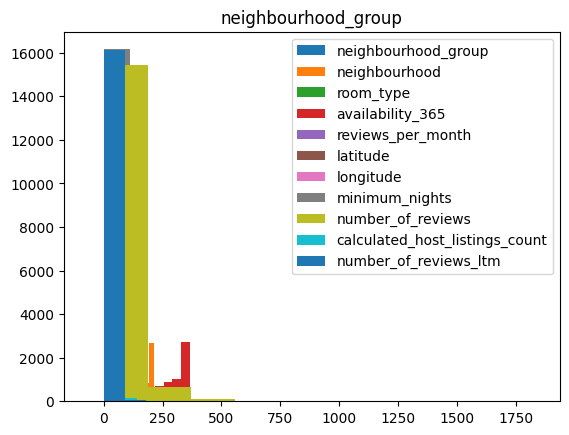

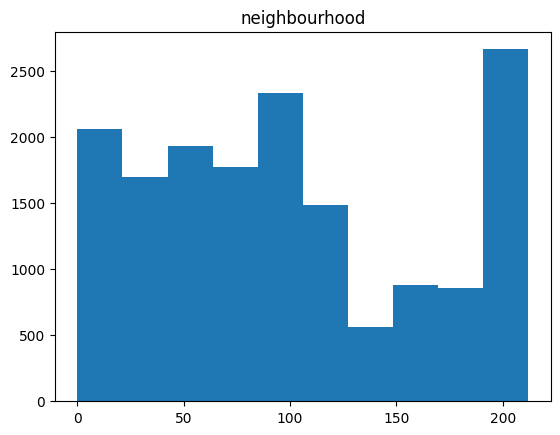

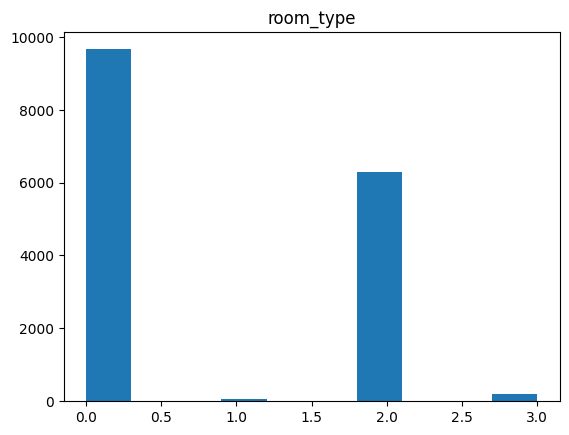

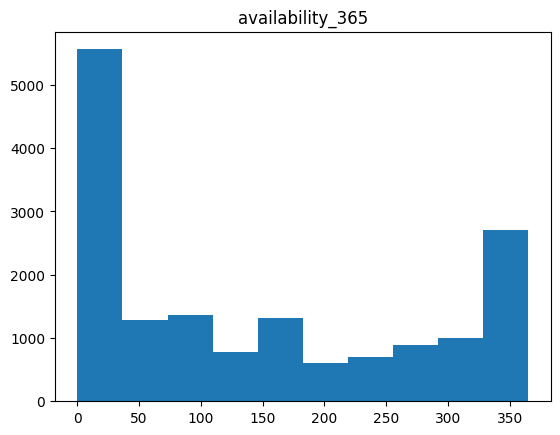

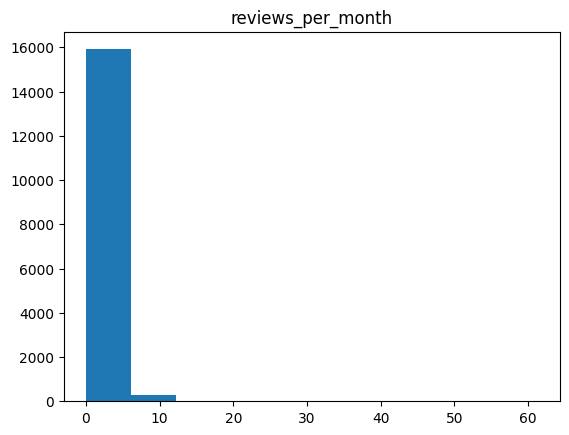

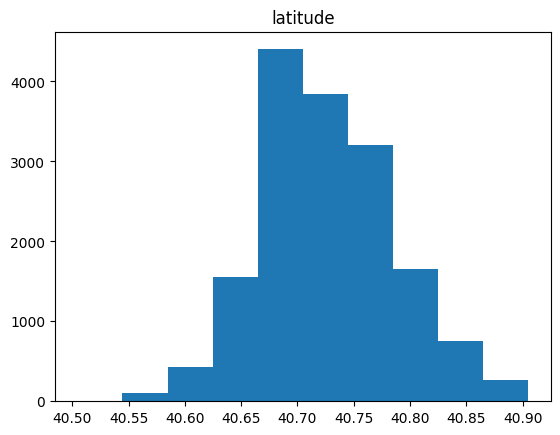

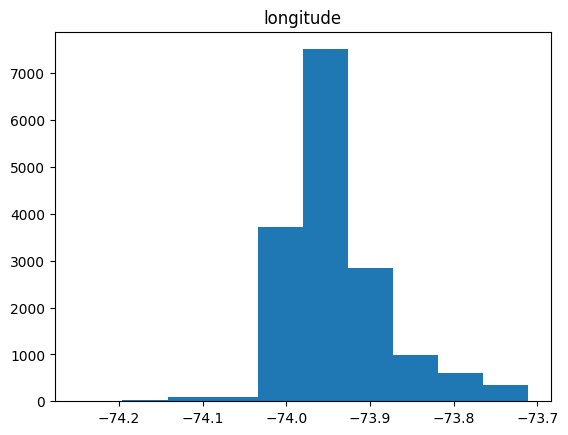

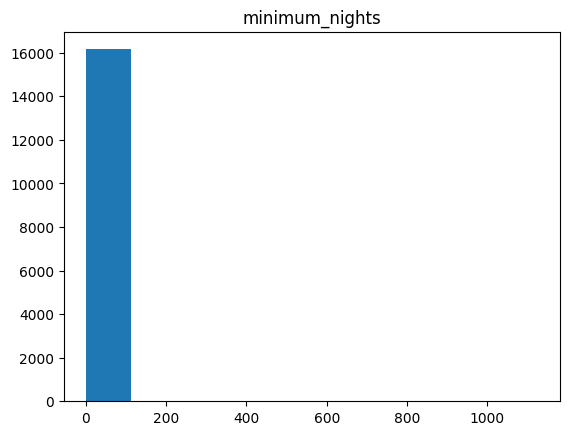

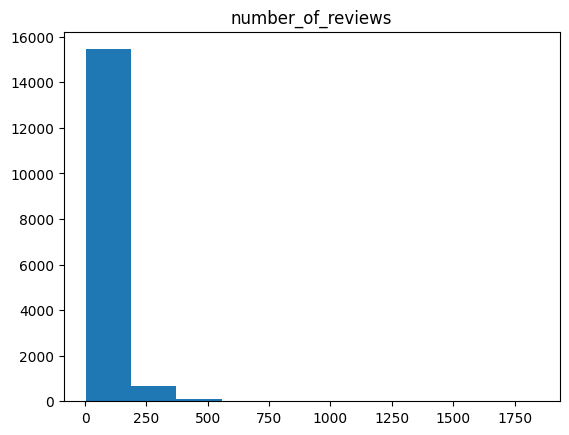

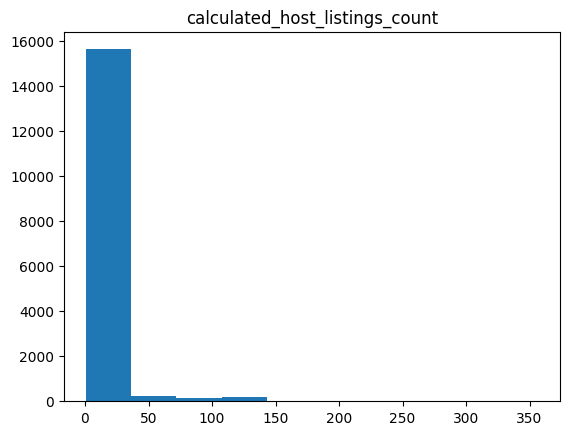

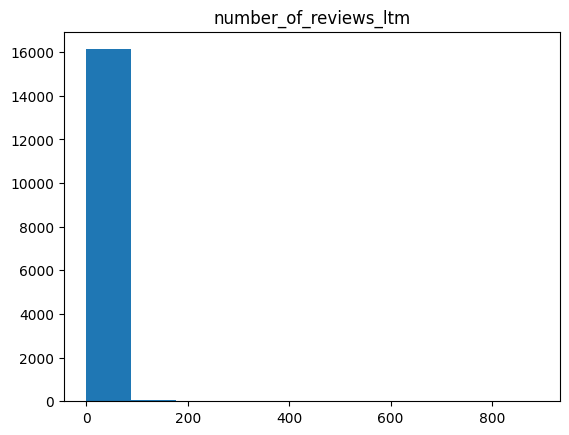

In [22]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
## encoding for columns with strings to unique for linear regression modelling
label_encoder = LabelEncoder()
train_data['neighbourhood_group'] = label_encoder.fit_transform(train_data['neighbourhood_group'])
train_data['neighbourhood'] = label_encoder.fit_transform(train_data['neighbourhood'])
train_data['room_type'] = label_encoder.fit_transform(train_data['room_type'])

test_data['neighbourhood_group'] = label_encoder.fit_transform(test_data['neighbourhood_group'])
test_data['neighbourhood'] = label_encoder.fit_transform(test_data['neighbourhood'])
test_data['room_type'] = label_encoder.fit_transform(test_data['room_type'])

## select important features/columns and get relevant rows
important_features = ['neighbourhood_group', 'neighbourhood', 'room_type', 'availability_365', 'reviews_per_month', 'latitude', 'longitude', 'minimum_nights','number_of_reviews', 'calculated_host_listings_count', 'number_of_reviews_ltm']
train_set = train_data[[feature for feature in important_features]]
test_set = test_data[[feature for feature in important_features]]
target_label = train_data['price']

## all plots combined
for feature in important_features:
  plt.hist(train_data[feature], label=feature)
  plt.title(feature)
plt.legend()

#individual plots
for feature in important_features:
  plt.hist(train_data[feature])
  plt.title(feature)
  plt.show()

**Simple Linear Model using sklearn linear regression package**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import pandas as pd

linear_model = LinearRegression()
simplest_model = linear_model.fit(train_set, target_label)
price_prediction = simplest_model.predict(test_set)


simple_linear_model_data = {'id': test_data['id'], 'price': price_prediction}
simple_linear_model_df = pd.DataFrame(simple_linear_model_data)
simple_linear_model_df.to_csv("slm_submission.csv", index=False)


**Advanced Linear model using sklearn Linear Regresssion - splitting training into training and validation sets to evaluate performance and select the best performing model according to the mean squared error value between the predicted validation set value and the actual value in the validation set**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.preprocessing import LabelEncoder

## Splitting data into different folds- each fold into training and validation set - and getting mean squared error
alm_num_folds = 5
alm_folds = KFold(n_splits=alm_num_folds, shuffle=True, random_state=35)
alm_all_models = []
alm_mse_values= []

for train_index, validation_index in folds.split(train_set):
    #split data into training and validation set
    train_set_fold, validation_set = train_set.iloc[train_index], train_set.iloc[validation_index]
    target_label_fold, validation_target = target_label.iloc[train_index], target_label.iloc[validation_index]

    # create a linear regression model with sklearn and train with the training fold
    linear_model = LinearRegression()
    alm_model = linear_model.fit(train_set_fold, target_label_fold)
    alm_all_models.append(alm_model)

    # make predictions on my validation set
    alm_validation_predictions = alm_model.predict(validation_set)

    # evaluate the efficacy of the current fold
    curr_mse = mean_squared_error(validation_target, alm_validation_predictions)

    # keep history of the
    alm_mse_values.append(curr_mse)

## select the best model - one with the least error from the prediction
best_model = alm_all_models[alm_mse_values.index(min(alm_mse_values))]

# predict the price for the test data
predicted_price = best_model.predict(test_set)

# save predictions
advanced_linear_model_data = {'id':test_data['id'], 'price':predicted_price}
advanced_linear_model_df = pd.DataFrame(advanced_linear_model_data)
advanced_linear_model_df.to_csv("alm_submission.csv", index=False)

**XGBoost Model - Performs better than the cross-validated linear regression model above depending the number of folds chosen to split the data**<br> Source:https://xgboost.readthedocs.io/en/stable/python/python_intro.html

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## creating folds
xgboost_num_folds = 5
xgboost_folds = KFold(n_splits=xgboost_num_folds, shuffle=True, random_state=35)
xgboost_all_models = []
mse_values_all_models = []

for train_index, validation_index in xgboost_folds.split(train_set):
    ## split the current fold to a training and validation set and evaluate the mean squared error using xgb model
    train_set_fold, validation_set = train_set.iloc[train_index], train_set.iloc[validation_index]
    target_label_fold, validation_target = target_label.iloc[train_index], target_label.iloc[validation_index]

    # Create and train the XGBoost model on the training set for this fold
    xgb_model = XGBRegressor()
    xgb_model.fit(train_set_fold, target_label_fold)
    xgboost_all_models.append(xgb_model)

    # Make predictions on the validation set
    validation_predictions = xgb_model.predict(validation_set)

    # Calculate the mean squared error for this fold
    curr_mse = mean_squared_error(validation_target, validation_predictions)
    mse_values_all_models.append(curr_mse)

# model with the least error based on the validation predictions mean squared error
best_fold_index = mse_values_all_models.index(min(mse_values_all_models))

# selecting the best model - model with the least mean squared error
best_xgb_model = xgboost_all_models[best_fold_index]

# predict for the test set using the best model identified above
predicted_price = best_xgb_model.predict(test_set)

## tabulate data and save if
xgb_submission_data = {'id':test_data['id'], 'price':predicted_price}
xgb_submission_df = pd.DataFrame(xgb_submission_data)
xgb_submission_df.to_csv("first_submission.csv", index=False)

**Bayes Optimization on XGBoost Model**<br> Source: https://github.com/bayesian-optimization/BayesianOptimization

In [23]:
!pip install bayesian-optimization
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization

param_space = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (200, 700),
    'max_depth': (2, 10)
}

# Define the objective function for Bayesian optimization
def bayes_impl(learning_rate, max_depth, n_estimators):
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth)
    }

    xgb_model = XGBRegressor(**params)
    bayes_num_folds = 5
    bayes_folds = KFold(n_splits=bayes_num_folds, shuffle=True, random_state=27)
    bayes_mse_values = []

    for train_index, validation_index in bayes_folds.split(train_set):
      ## split the current fold to a training and validation set and evaluate the mean squared error using xgb model
      train_set_fold, validation_set = train_set.iloc[train_index], train_set.iloc[validation_index]
      target_label_fold, validation_target = target_label.iloc[train_index], target_label.iloc[validation_index]

      # Create and train the XGBoost model on the training set for this fold
      xgb_model.fit(train_set_fold, target_label_fold)

      # Make predictions on the validation set
      validation_predictions = xgb_model.predict(validation_set)

      # Calculate the mean squared error for this fold
      curr_mse = mean_squared_error(validation_target, validation_predictions)
      bayes_mse_values.append(curr_mse)

    return -sum(bayes_mse_values)/len(bayes_mse_values)

# Bayesian optimization to tune hyperparameters
optimizer = BayesianOptimization(f=bayes_impl, pbounds=param_space)
optimizer.maximize(init_points=5, n_iter=10)

# best parameters identified by the Bayes optimization - shown as the program runs too
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# using the best params found to generate the most optimal linear regression mode
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(train_set, target_label)
predicted_price = best_xgb_model.predict(test_set)

print('Params to used ',best_params['learning_rate'])
bayes_opt_submission_data = {'id':test_data['id'], 'price':predicted_price}
bayes_opt_submission_df = pd.DataFrame(bayes_opt_submission_data)
bayes_opt_submission_df.to_csv("first_submission.csv", index=False)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -1.61e+04 | 0.1377    | 9.345     | 487.3     |
| 2         | -1.596e+0 | 0.1699    | 5.826     | 471.9     |
| 3         | -1.574e+0 | 0.09653   | 8.224     | 588.9     |
| 4         | -1.541e+0 | 0.1978    | 4.032     | 203.9     |
| 5         | -1.534e+0 | 0.06187   | 8.229     | 321.8     |
| 6         | -1.656e+0 | 0.02451   | 2.022     | 266.0     |
| 7         | -1.587e+0 | 0.1427    | 8.375     | 320.6     |
| 8         | -1.517e+0 | 0.02111   | 5.338     | 603.7     |
| 9         | -1.645e+0 | 0.1875    | 8.532     | 434.2     |
| 10        | -1.54e+04 | 0.02683   | 9.434     | 563.6     |
| 11        | -1.645e+0 | 0.0358    | 2.885     | 212.7     |
| 12        | -1.587e+0 | 0.06057   | 2.093     | 698.4     |
| 13        | -1.519e+0 | 0.01867   | 5.431     | 603.7     |
| 14        | -1.537e+0 | 0.09001   | 4.398     | 605.2     |
| 15    